### Library

In [1]:
import re
import glob
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from scipy import stats
from scipy.stats import uniform, zscore

### Dataset

In [2]:
file_paths = glob.glob('D:/data/raw/*.csv')
if not file_paths:
    raise FileNotFoundError("No CSV files found in the specified directory.")

data = pd.concat([pd.read_csv(file) for file in file_paths], ignore_index=True)
data.to_csv('C:/Users/Kayaki/ta_project/data/processed/combined_data.csv', index=False)
print(f"✅ Successfully combined {len(file_paths)} CSV files")

FileNotFoundError: No CSV files found in the specified directory.

In [ ]:
df = pd.read_csv('D:/data/processed/combined_data.csv')
df.head(5)

,No,Model Pakaian,Jenis Bahan,Waktu Pengerjaan (hari),Detail Tambahan,Harga Jasa (Rp)
0,1,Kebaya Tradisional,Katun,25,"bordir tangan, bawah, payet aksen",Rp750.000
1,2,Kebaya Tradisional,Katun,7,renda,Rp250.000
2,3,Kebaya Tradisional,Sutra,10,-,Rp350.000
3,4,Kebaya Tradisional,Sutra,25,"payet aksen tangan, panel dada",Rp700.000
4,5,Kebaya Tradisional,Brokat,14,-,Rp350.000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   No                       739 non-null    int64 
 1   Model Pakaian            739 non-null    object
 2   Jenis Bahan              739 non-null    object
 3   Waktu Pengerjaan (hari)  739 non-null    int64 
 4   Detail Tambahan          739 non-null    object
 5   Harga Jasa (Rp)          739 non-null    object
dtypes: int64(2), object(4)
memory usage: 34.8+ KB


In [ ]:
print(df.isnull().sum())

No                         0
Model Pakaian              0
Jenis Bahan                0
Waktu Pengerjaan (hari)    0
Detail Tambahan            0
Harga Jasa (Rp)            0
dtype: int64


### Data Cleaning

In [ ]:
if 'No' in df.columns:
    df.drop(labels=['No'], axis=1, inplace=True)

In [ ]:
df = df.rename(columns={
    'Model Pakaian': 'model',
    'Jenis Bahan': 'bahan',
    'Waktu Pengerjaan (hari)': 'waktu_pengerjaan',
    'Detail Tambahan': 'ornamen',
    'Harga Jasa (Rp)': 'harga_jasa'
})

In [ ]:
def clean_price(price):
    cleaned = re.sub(r'[^\d]', '', str(price))
    return int(cleaned) if cleaned else None

df['harga_jasa'] = df['harga_jasa'].apply(clean_price)
df = df.dropna(subset=['harga_jasa'])

In [ ]:
model_mapping = {
    'Gaun midi': 'midi dress',
    'Gaun maxi': 'maxi dress'
}

df['model'] = df['model'].replace(model_mapping)

In [ ]:
cat_cols = ['model', 'bahan', 'ornamen']

for col in cat_cols:
    df[col] = df[col].str.title().str.strip()

In [ ]:
# Ornament keyword mapping
ornament_keywords = {
    'Bordir': ['Bordir', 'Bordit'],
    'Payet': ['Payet', 'Payat'],
    'Renda': ['Renda'],
    'Opneisel': ['Opneisel', '0pneisel'],
    'None': ['-']
}

# Detect ornament labels
def labels_detection(text):
    if pd.isna(text):
        return []
    labels = set()
    for label, keywords in ornament_keywords.items():
        if any(kw in text for kw in keywords):
            labels.add(label)
    return list(labels)

# Apply detection and store as list
df['ornament_list'] = df['ornamen'].apply(labels_detection)

In [ ]:
# Filter rows with only one ornament
df = df[df['ornament_list'].apply(len) == 1].copy()

# Convert list back to string
df['ornamen'] = df['ornament_list'].apply(lambda x: x[0] if x else 'none')
df.drop(columns=['ornament_list'], inplace=True)

In [ ]:
print("✅ Preprocessing complete! Final dataset shape:", df.shape)

✅ Preprocessing complete! Final dataset shape: (676, 5)


### Exploratory Data Analysis

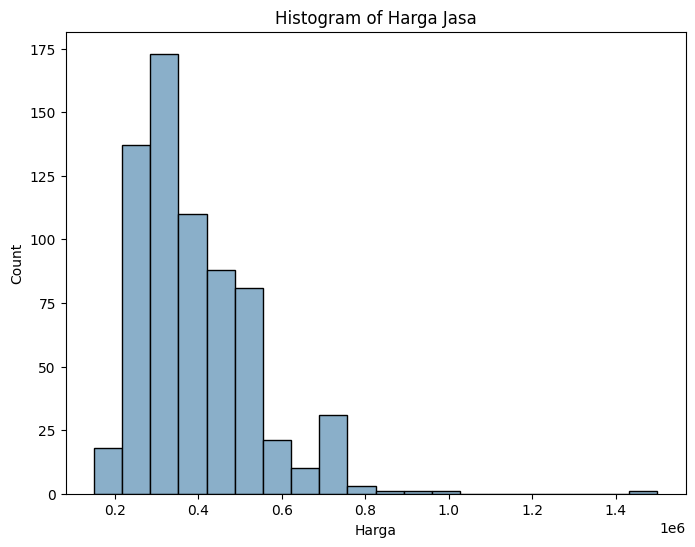

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['harga_jasa'], bins=20, color='#8aafc9', edgecolor='black')
plt.title('Histogram of Harga Jasa')
plt.xlabel('Harga')
plt.ylabel('Count')
plt.show()

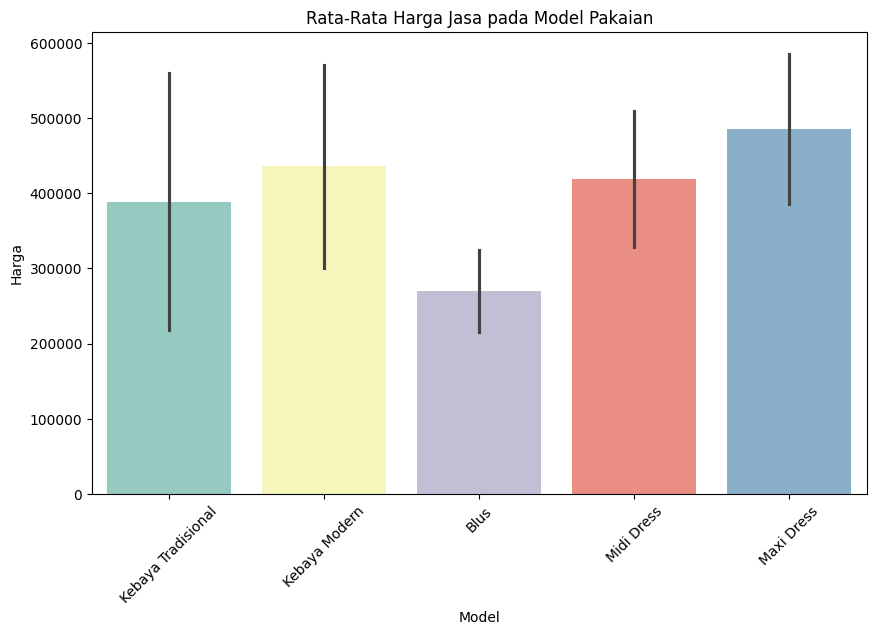

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='harga_jasa', data=df, errorbar='sd', palette='Set3', hue='model')
plt.title('Rata-Rata Harga Jasa pada Model Pakaian')
plt.xlabel('Model')
plt.ylabel('Harga')
plt.xticks(rotation=45)
plt.show()

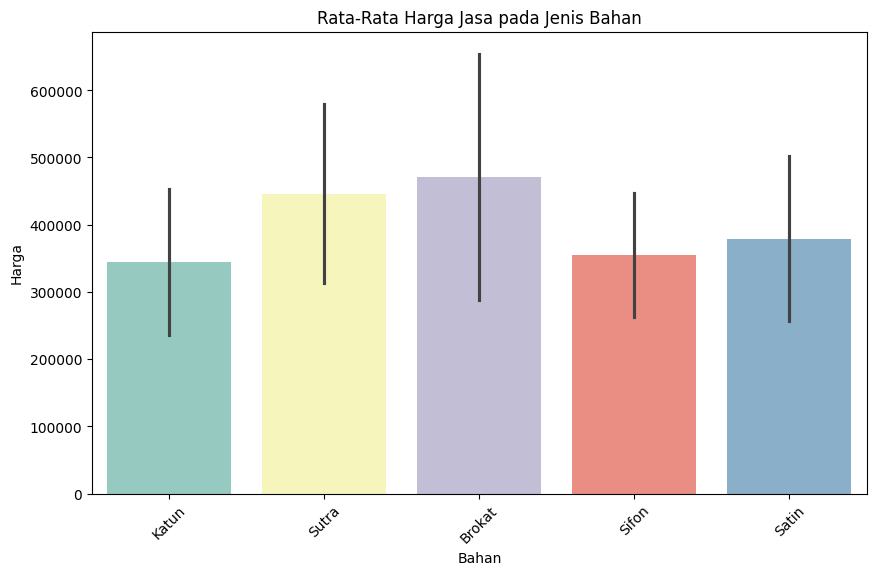

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='bahan', y='harga_jasa', data=df, errorbar='sd', palette='Set3', hue='bahan')
plt.title('Rata-Rata Harga Jasa pada Jenis Bahan')
plt.xlabel('Bahan')
plt.ylabel('Harga')
plt.xticks(rotation=45)
plt.show()

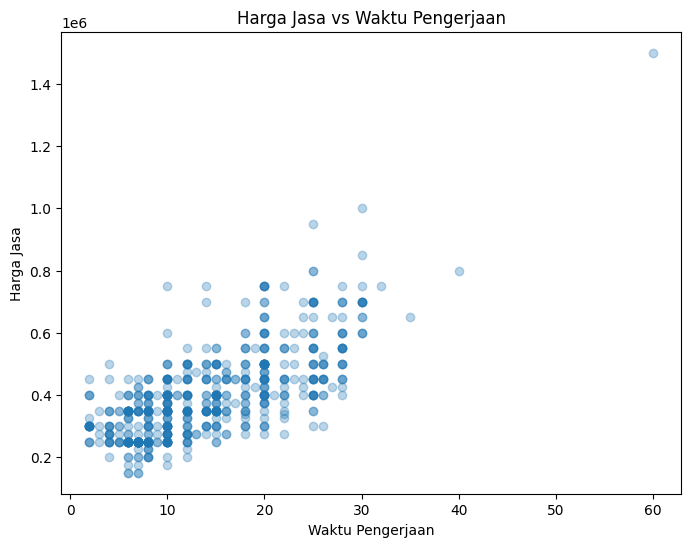

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df['waktu_pengerjaan'], df['harga_jasa'], alpha=0.3)
plt.title('Harga Jasa vs Waktu Pengerjaan')
plt.xlabel('Waktu Pengerjaan')
plt.ylabel('Harga Jasa')
plt.show()

### Outlier Handling

In [ ]:
# Z-score
z_scores = abs(zscore(df[['waktu_pengerjaan', 'harga_jasa']]))
threshold = 3  # Outlier jika Z-score > 3
df_no_outliers = df[(z_scores < threshold).all(axis=1)]

### Train Test Split

In [ ]:
# # Split data
X = df_no_outliers.drop('harga_jasa', axis=1)
y = df_no_outliers['harga_jasa']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

### Modelling

In [ ]:
# Tranformation
trans = ColumnTransformer(
    transformers=[
        ('col', OneHotEncoder(sparse_output=False, drop='first'), cat_cols)
    ], 
    remainder='passthrough'
)

In [ ]:
# Linear Regression
lr = LinearRegression()

pipe1 = Pipeline([
    ('transform', trans),
    ('model', lr)
])

pipe1.fit(X_train, y_train)

y_pred1 = pipe1.predict(X_test)

r2_lr = r2_score(y_test, y_pred1)
mae_lr = mean_absolute_error(y_test, y_pred1)

In [ ]:
# Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=100, 
                            max_depth=15, 
                            max_features=0.75, 
                            max_samples=0.5, 
                            random_state=3)

pipe2 = Pipeline([
    ('transform', trans),
    ('model', rfr)
])

pipe2.fit(X_train, y_train)

y_pred2 = pipe2.predict(X_test)

r2_rfr = r2_score(y_test, y_pred2)
mae_rfr = mean_absolute_error(y_test, y_pred2)

In [ ]:
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=500, 
                                learning_rate=0.1,
                                max_depth=3,
                                subsample=0.8,
                                random_state=3)

pipe3 = Pipeline([
    ('transform', trans),
    ('model', gbr)
])

pipe3.fit(X_train, y_train)

y_pred3 = pipe3.predict(X_test)

r2_gbr = r2_score(y_test, y_pred3)
mae_gbr = mean_absolute_error(y_test, y_pred3)

In [ ]:
basic_test_eval = pd.DataFrame({
    'R2': [r2_lr, r2_rfr, r2_gbr], 
    'MAE': [mae_lr, mae_rfr, mae_gbr]
}, index=['Linear Regression', 'Random Forest Regressor','Gradient Boosting Regressor'])

basic_test_eval

,R2,MAE
Linear Regression,0.741377,48132.677792
Random Forest Regressor,0.788630,44454.739039
Gradient Boosting Regressor,0.792503,44619.830130


### Tuning RandomSearh + GridSearch

In [ ]:
# 1. Definisi model dan parameter search space
regularization_models = {
    'Linear Regression': (LinearRegression(), {}),
    'Ridge Regression': (Ridge(), {'model__alpha': uniform(0.0001, 50)}),
    'Lasso Regression': (Lasso(max_iter=10000), {'model__alpha': uniform(0.0001, 100)}),
    'ElasticNet': (ElasticNet(max_iter=10000), {
        'model__alpha': uniform(0.0001, 0.5),
        'model__l1_ratio': uniform(0.1, 0.8)
    })
}

# 2. Menyimpan hasil evaluasi
r2_scores = {}
mae_scores = {}

In [ ]:
## 3. Training dan evaluasi
for name, (model, param_dist) in regularization_models.items():
    print(f"🔍 Model: {name}")
    
    pipe = Pipeline([
        ('transform', trans), 
        ('model', model)
    ])
    
    if param_dist:
        # ➡️ Random Search
        print("➡️ Melakukan RandomizedSearchCV...")
        print("➡️ Parameter distribusi untuk RandomizedSearchCV:")
        print(param_dist)
        
        random_search = RandomizedSearchCV(
            pipe, 
            param_distributions=param_dist, 
            n_iter=25, 
            cv=5, 
            scoring='neg_mean_squared_error',
            error_score='raise',
            random_state=42
        )
        random_search.fit(X_train, y_train)

        # Ambil parameter terbaik dari random search
        print("✅ Best params dari RandomizedSearchCV:")
        print(random_search.best_params_)
        print("🔢 Best score (neg MSE):", random_search.best_score_)
        
        # ➡️ Fokuskan Grid Search di sekitar best_params
        best_params = random_search.best_params_
        refined_grid = {}
        for param_name, best_val in best_params.items():
            if 'l1_ratio' in param_name:
                lower = max(0.0, best_val * 0.8)
                center = min(1.0, best_val)
                upper = min(1.0, best_val * 1.2)
                refined_grid[param_name] = sorted(set([lower, center, upper]))
            else:
                refined_grid[param_name] = list(np.linspace(0.3 * best_val, 1.7 * best_val, 15))
        
        print("🔧 Refined grid untuk GridSearchCV:")
        print(refined_grid)
        
        print("➡️ Melakukan GridSearchCV dengan refined grid...")
        grid_search = GridSearchCV(
            pipe, 
            param_grid=refined_grid, 
            cv=5, 
            scoring='neg_mean_squared_error'
        )
        grid_search.fit(X_train, y_train)

        print("✅ Best params dari GridSearchCV:")
        print(grid_search.best_params_)
        print("🔢 Best score (neg MSE):", grid_search.best_score_)

        best_model = grid_search.best_estimator_
    else:
        print("➡️ Tidak ada parameter untuk dituning. Langsung fit.")
        pipe.fit(X_train, y_train)
        best_model = pipe

    # Prediksi dan evaluasi
    y_pred = best_model.predict(X_test)
    r2_scores[name] = r2_score(y_test, y_pred)
    mae_scores[name] = mean_absolute_error(y_test, y_pred)
    
    print("📊 Hasil evaluasi di data uji:")
    print(f"R² Score: {r2_scores[name]:.4f}")
    print(f"MAE: {mae_scores[name]:.4f}\n")

🔍 Model: Linear Regression
➡️ Tidak ada parameter untuk dituning. Langsung fit.
📊 Hasil evaluasi di data uji:
R² Score: 0.7414
MAE: 48132.6778

🔍 Model: Ridge Regression
➡️ Melakukan RandomizedSearchCV...
➡️ Parameter distribusi untuk RandomizedSearchCV:
{'model__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002338A22AD90>}
✅ Best params dari RandomizedSearchCV:
{'model__alpha': np.float64(1.0293247147901223)}
🔢 Best score (neg MSE): -4207645259.109276
🔧 Refined grid untuk GridSearchCV:
{'model__alpha': [np.float64(0.3087974144370367), np.float64(0.4117298859160489), np.float64(0.5146623573950612), np.float64(0.6175948288740734), np.float64(0.7205273003530857), np.float64(0.8234597718320978), np.float64(0.92639224331111), np.float64(1.0293247147901223), np.float64(1.1322571862691344), np.float64(1.2351896577481467), np.float64(1.338122129227159), np.float64(1.4410546007061713), np.float64(1.5439870721851834), np.float64(1.6469195436641957), np.float64(1

In [ ]:
# 4. Buat tabel hasil evaluasi
test_eval = pd.DataFrame({
    'R2': [
        r2_scores['Linear Regression'],
        r2_scores['Ridge Regression'],
        r2_scores['Lasso Regression'],
        r2_scores['ElasticNet']
    ],
    'MAE': [
        mae_scores['Linear Regression'],
        mae_scores['Ridge Regression'],
        mae_scores['Lasso Regression'],
        mae_scores['ElasticNet']
    ]
}, index=['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet'])

test_eval

,R2,MAE
Linear Regression,0.741377,48132.677792
Ridge Regression,0.741646,48087.916084
Lasso Regression,0.741787,48146.575715
ElasticNet,0.741655,48083.686808


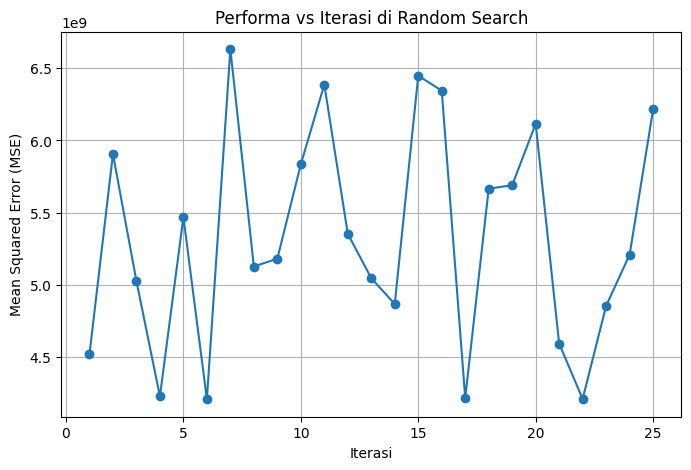

In [ ]:
# Misal kamu punya random_search dari salah satu model
# random_search = hasil RandomizedSearchCV tadi

# Ambil skor dari hasil random search
search_results = random_search.cv_results_
mean_test_scores = -search_results['mean_test_score']  # karena scoring = neg_mean_squared_error
iterations = np.arange(1, len(mean_test_scores) + 1)

# Plot
plt.figure(figsize=(8,5))
plt.plot(iterations, mean_test_scores, marker='o')
plt.xlabel('Iterasi')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Performa vs Iterasi di Random Search')
plt.grid(True)
plt.show()

### Tuning GridSearch

In [ ]:
# Linear Regression
# 1. Definisi model dan parameter grid
regularization_models = {
    'Linear Regression': (LinearRegression(), {}),
    'Ridge Regression': (Ridge(), {'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100]}),
    'Lasso Regression': (Lasso(max_iter=10000), {'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}),
    'ElasticNet': (ElasticNet(max_iter=10000), {
        'model__alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1],
        'model__l1_ratio': [0.1, 0.5, 0.7, 0.8, 0.9, 1]
    })
}

# 2. Menyimpan hasil evaluasi
r2_scores = {}
mae_scores = {}

# 3. Training dan evaluasi
for name, (model, param_grid) in regularization_models.items():
    pipe = Pipeline([
        ('transform', trans),  # pastikan 'trans' sudah didefinisikan sebelumnya
        ('model', model)
    ])
    
    if param_grid:
        grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
    else:
        pipe.fit(X_train, y_train)
        best_model = pipe

    y_pred = best_model.predict(X_test)
    r2_scores[name] = r2_score(y_test, y_pred)
    mae_scores[name] = mean_absolute_error(y_test, y_pred)

# 4. Buat tabel hasil evaluasi
test_eval = pd.DataFrame({
    'R2': [
        r2_scores['Linear Regression'],
        r2_scores['Ridge Regression'],
        r2_scores['Lasso Regression'],
        r2_scores['ElasticNet']
    ],
    'MAE': [
        mae_scores['Linear Regression'],
        mae_scores['Ridge Regression'],
        mae_scores['Lasso Regression'],
        mae_scores['ElasticNet']
    ]
}, index=['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet'])

test_eval

,R2,MAE
Linear Regression,0.741377,48132.677792
Ridge Regression,0.741636,48073.816604
Lasso Regression,0.741417,48132.812912
ElasticNet,0.741656,48080.742244


In [ ]:
# best_reg_model = 'Ridge Regression'

In [ ]:
# # Random Forest
# rfr = RandomForestRegressor(random_state=3)

# pipe2 = Pipeline([
#     ('transform', trans),
#     ('model', rfr)
# ])

# # Hyperparameter Grid
# param_grid = {
#     'model__n_estimators': [100, 200, 500],
#     'model__max_depth': [10, 20, 30],
#     'model__max_features': [0.5, 0.75, 'sqrt', 'log2'],
#     'model__min_samples_split': [2, 5, 10],
#     'model__min_samples_leaf': [1, 2, 4],
#     'model__max_samples': [0.5, 0.75, 1.0]
# }

# # Grid Search
# grid_rf = GridSearchCV(pipe2, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
# grid_rf.fit(X_train, y_train)

# # Best hyperparameters
# print("Best Params (Random Forest):", grid_rf.best_params_)

# # Prediction
# y_pred2 = grid_rf.best_estimator_.predict(X_test)

In [ ]:
# gbr = GradientBoostingRegressor(random_state=3)

# pipe3 = Pipeline([
#     ('transform', trans),
#     ('model', gbr)
# ])

# # Hyperparameter grid
# param_grid = {
#     'model__n_estimators': [100, 300, 500],
#     'model__learning_rate': [0.01, 0.05, 0.1],
#     'model__max_depth': [3, 5, 7],
#     'model__subsample': [0.6, 0.8, 1.0],
#     'model__min_samples_split': [2, 5, 10],
#     'model__min_samples_leaf': [1, 2, 4]
# }

# # Grid Search
# grid_gbr = GridSearchCV(pipe3, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
# grid_gbr.fit(X_train, y_train)

# # Best hyperparameters
# print("Best Params (Gradient Boosting):", grid_gbr.best_params_)

# # Prediction
# y_pred3 = grid_gbr.best_estimator_.predict(X_test)

In [ ]:
# r2_lr = r2_scores[best_reg_model]
# mae_lr = mae_scores[best_reg_model]

# r2_rfr = r2_score(y_test, y_pred2)
# mae_rfr = mean_absolute_error(y_test, y_pred2)

# r2_gbr = r2_score(y_test, y_pred3)
# mae_gbr = mean_absolute_error(y_test, y_pred3)

In [ ]:
# tuning_test_eval = pd.DataFrame({
#     'R2': [r2_lr, r2_rfr, r2_gbr], 
#     'MAE': [mae_lr, mae_rfr, mae_gbr]
# }, index=['Ridge Regression', 'Random Forest Regressor','Gradient Boosting Regressor'])

# tuning_test_eval

### Prediction

In [ ]:
# def predict_price(model_input, bahan_input, ornamen_input, waktu_input):
#     df_input = pd.DataFrame([{
#         'model': model_input,
#         'bahan': bahan_input,
#         'ornamen': ornamen_input,
#         'waktu_pengerjaan': waktu_input
#     }])
    
#     # Prediksi langsung pakai pipeline
#     pred = pipe1.predict(df_input)[0]
#     rentang = (int(pred - 100000), int(pred + 100000))
#     return f"Estimasi harga jasa jahit: Rp{rentang[0]:,} - Rp{rentang[1]:,}"

In [ ]:
# # Contoh prediksi
# print(predict_price("Kebaya Tradisional", "Brokat", "Payet", 7))

In [ ]:
# # Save model
# joblib.dump(pipe1, 'C:/Users/Kayaki/ta_project/models/model.pkl')

### Evaluation

In [ ]:
# plt.figure(figsize=(8, 6))
# plt.scatter(y_test, y_pred2, alpha=0.7)
# plt.xlabel("Actual")
# plt.ylabel("Predicted")
# plt.title("Actual vs Predicted Harga Jasa")
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
# plt.show()